# Fuzzed vs Vanilla flight path analysis

## Crash count: 3/15

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw
import csv
from statistics import * 

### We generate the csv files via the ulog2csv utility and target the vehicle_local_position message

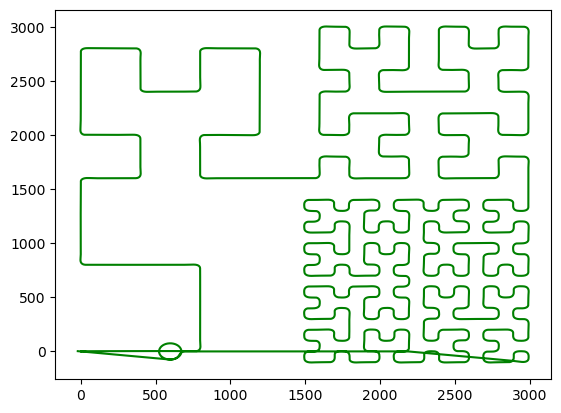

In [11]:
vanilla_pos_df = pd.read_csv("rcac_autopilot/vanilla/vl0_vehicle_local_position_0.csv")
plt.plot(vanilla_pos_df["y"], vanilla_pos_df["x"], "g")
plt.show()

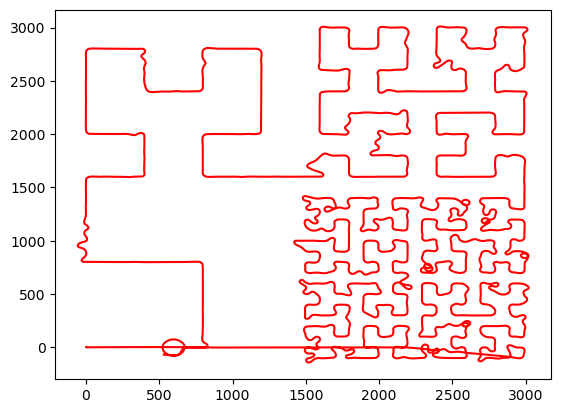

In [12]:
fuzzed_pos_df = pd.read_csv("rcac_autopilot/fuzzed/fzl0_vehicle_local_position_0.csv")
plt.plot(fuzzed_pos_df["y"], fuzzed_pos_df["x"], "r")
plt.show()

In [3]:
def df2path(df):
    return np.transpose(np.stack((df["x"], df["y"])))

def log2path_standard(isVanilla, index):
    """Takes vanilla or fuzzed index and returns a 2d array of x,y coordinates"""
    prefix = "standard_autopilot/vanilla/vl" if isVanilla else "standard_autopilot/fuzzed/fzl"
    pdf = pd.read_csv(prefix + str(index) + "_vehicle_local_position_0.csv")
    return df2path(pdf)

def log2path_rcac(isVanilla, index):
    """Takes vanilla or fuzzed index and returns a 2d array of x,y coordinates"""
    prefix = "rcac_autopilot/vanilla/vl" if isVanilla else "rcac_autopilot/fuzzed/fzl"
    pdf = pd.read_csv(prefix + str(index) + "_vehicle_local_position_0.csv")
    return df2path(pdf)

In [5]:
vanilla_path  = log2path_rcac(True, 0)
fuzzed_path  = log2path_rcac(False, 0)
vf_distance, vf_path = fastdtw(vanilla_path, fuzzed_path)
print(vf_distance)

392289.87679127895


### Now we can construct a similarity matrix with the dynamic-time-warping as a distance metric
Below is the similarity matrix for the unfuzzed trials

In [14]:
NUM_TRIALS = 5
vanilla_simmat = np.zeros((NUM_TRIALS, NUM_TRIALS))
for i in range(NUM_TRIALS):
    for j in range(1, NUM_TRIALS-i):
        p1 = log2path_rcac(True, i)
        p2 = log2path_rcac(True, j)
        wdist, dtwpath = fastdtw(p1, p2)
        vanilla_simmat[i, i+j] = wdist
print(vanilla_simmat)

alldists = np.array([i for i in filter(lambda x: x != 0, vanilla_simmat.flat)])
m = mean(alldists)
print("rcac vanilla simmat mean:", m, "stdev:", stdev(alldists))
print("rcac vanilla normalized simmat mean:", mean(alldists/m), "stdev:", stdev(alldists/m))

with open("rcac_vanilla_similarity.csv", "w+") as sim_csv:
    csvWriter = csv.writer(sim_csv, delimiter=',')
    csvWriter.writerows(vanilla_simmat)

[[    0.         17542.27045473 18824.04407703 19406.93851144
  16718.82062337]
 [    0.             0.             0.         18128.72552915
  20078.27745066]
 [    0.             0.             0.         18128.72552915
      0.        ]
 [    0.             0.             0.             0.
  20078.27745066]
 [    0.             0.             0.             0.
      0.        ]]
rcac vanilla simmat mean: 18613.259953274006 stdev: 1205.4859264936588
rcac vanilla normalized simmat mean: 1.0 stdev: 0.06476490037316746


Below is the similarity matrix for the fuzzed trials

In [5]:
NUM_TRIALS = 12
fuzzed_simmat = np.zeros((NUM_TRIALS, NUM_TRIALS))
for i in range(NUM_TRIALS):
    for j in range(1, NUM_TRIALS-i):
        p1 = log2path_rcac(False, i)
        p2 = log2path_rcac(False, j)
        wdist, dtwpath = fastdtw(p1, p2)
        fuzzed_simmat[i, i+j] = wdist
print(fuzzed_simmat)

[[     0.         496094.32168956 406829.73827942 606621.1044077
  490323.3107266  453841.91709816 654676.29239574 473605.2373444
  458412.58020208 644351.52970458 539257.7531947  497204.10531518]
 [     0.              0.              0.         419202.13346698
  597140.1626702  528774.86182291 534987.32177529 640481.90570437
  525913.25019857 444693.23017014 645185.67675487 543346.41783084]
 [     0.              0.              0.         419202.13346698
       0.         563223.60936007 458206.8440646  467096.90437015
  601722.36429212 435291.69720554 378199.64948839 598031.19302578]
 [     0.              0.              0.              0.
  597140.1626702  563223.60936007      0.         549572.94282398
  616075.99014018 442875.37950558 626822.87978008 562746.60454068]
 [     0.              0.              0.              0.
       0.         528774.86182291 458206.8440646  549572.94282398
       0.         513279.33979999 598874.85683012 507640.1882383 ]
 [     0.              

In [6]:
alldists = np.array([i for i in filter(lambda x: x != 0, fuzzed_simmat.flat)])
m = mean(alldists)
print("rcac fuzzed simmat mean:", m, "stdev:", stdev(alldists))
print("rcac fuzzaed normalized simmat mean:", mean(alldists/m), "stdev:", stdev(alldists/m))

simmat mean: 535023.3360134163 stdev: 78018.39282561518
normalized simmat mean: 1.0 stdev: 0.14582241105023275


In [7]:
with open("rcac_fuzzed_similarity.csv", "w+") as sim_csv:
    csvWriter = csv.writer(sim_csv, delimiter=',')
    csvWriter.writerows(fuzzed_simmat)

### Now we can calculate the average deviation from an unfuzzed path

In [15]:
vanilla_dists = []
vanilla_path = log2path_rcac(True, 0)

for i in range(NUM_TRIALS):
    fuzzed_path =  log2path_rcac(False, i)
    vf_distance, vf_path = fastdtw(vanilla_path, fuzzed_path)
    vanilla_dists.append(vf_distance)
print(vanilla_dists)

[561963.500227212, 467896.2978244694, 419840.6114306841, 284656.46040071844, 433030.38736271294]


In [16]:
print("mean distance between fuzzed and unfuzzed trials:", mean(vanilla_dists), "stdev:", stdev(vanilla_dists))
print("normalized mean:", 1.0, "stdev:", stdev(vanilla_dists/mean(vanilla_dists)))

mean distance between fuzzed and unfuzzed trials: 433477.45144915936 stdev: 100033.95968998517
normalized mean: 1.0 stdev: 0.23077084945378687


In [17]:
with open("rcac_vf_distances.csv", "w") as vf_dist_csv:
    csvWriter = csv.writer(vf_dist_csv, delimiter=',')
    csvWriter.writerow(np.transpose(vanilla_dists))